<a href="https://colab.research.google.com/github/skybristol/experiments/blob/dev/NMIC_DS140.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Prospectus
*A new method for integrated commodity statistics data and a cloud-based distribution point to enable expanded utility of the DS140 report*

# Background and Goal
An initial goal for the USGS National Minerals Information Center toward modernizing data processing and distribution workflows is to transform the Historical Statistics for Mineral and Material Commodities in the United States (aka [DS140 report](https://www.usgs.gov/centers/nmic/historical-statistics-mineral-and-material-commodities-united-states)), into a new data model that supports alternative methods for query, reporting, and usage. Initial focus is on the supply-demand statistics, which are distributed as Excel spreadsheets with varying formats, structures, and properties. In the long run, we may come up with a process that works directly from an alternative, more original source for these data to some type of standardized output that we can operate against.

In the near term, this notebook presents a proposal to explore what a process would need to consist of to work directly with the data as presented online via the DS140 distribution site linked above. The goal is to produce a dynamic system that will operate in the USGS cloud to transform the existing DS140 data and any new files posted to that "running" Data Series into an amalgamated database, complete with individual commodity metadata. This database will be made available via an application programming interface (API) as a mimumum viable product along with documentation for use and a simple user interface that demonstrates the API functionality.

Note: In the process of pursuing this idea, we may end up either working with a more fundamental and simply structured form of output data that comes from internal systems to the DS140 distribution point, and we may extend our thinking a bit beyond the DS140 to other data that are distributed from NMIC's processes. The size of data and amount of processes needed are not particularly constraining factors. Rather, the level of complexity in the underlying data and the need to work efficiently back and forth between code development/infrastructure deployment and data subject matter expertise will likely be the area of scope limitation.

# Approach
This notebook lays out a conceptual approach to the problem using Python code and a set of open source libraries to connect to the DS140 inventory of annual commodity statistics source files, read the files from Excel, and process the statistics and individual commodity metadata into an alternative data structure. This provides the basic elements for what could be instantiated as a serverless processing pipeline in the USGS cloud. As part of the project, we will explore options for this basic approach to include native "extract/transform/load" utilities as well as an approach using more vendor-agnostic methods and report on relative costs and trade-offs to the alternate methods. The project will also report on characteristics in the underlying source data and how they are currently provisioned to help inform future work at the point of production and release.

The code notebook, as a method for documenting a project proposal, is itself an exploration of a new method and way of thinking about problems in data and technology we are seeking to address. Rather than only provide words that describe an idea, the notebook exercises code and processing methods that demonstrate the idea and test feasibility of the approach. If accepted as a project to move forward, the code serves as a starting point, potentially providing working process that can be further developed into a working system. The note sections provide further details about the thinking involved and demonstrate the direction the proposers are seeking to pursue.

# Future Implications
This project will test applicable design principles being developed toward a future USGS Geoscience Data System architecture. It specifically targets the concept of iterative, incremental development where we seek to take large problems, break them into actionable chunks, and work to produce something that has immediate value while working stepwise to reduce the larger problems. It persues the concept of loose coupling, building a microservice infrastructure that leverages existing data serving infrastructure (simplicity of USGS web distribution) while layering on small tools that can be composed in a different way for some other purpose. These principles will be tested in practice and described in presentation of results to inform their future development.

Other aspects of the NMIC data processing and distribution infrastructure may benefit directly from demonstrating this particular approach. Either native tools to the current Amazon Web Services environment in use by the USGS Cloud or something more transportable will demonstrate basic data handling methods applicable to both proprietary and nonproprietary aspects of the NMIC data environment. Techniques and methods developed for this project can be lifted and adapted to other parts of the infrastructure to add incremental value, achieve efficiencies, and produce new types of end user value from the data.

# Project Team
We are deliberately working to develop a small project team with the majority of the resources contributed through a dedicated pilot effort funded by the Energy and Minerals Mission Area (EMMA). The project will be conducted fully in the open with regular opportunities for input welcome from anyone with an interest.

* Architect: Sky Bristol (on detail with EMMA designing and future USGS Geoscience Data System)
* Developer: Jay Shah (contractor from the USGS Cloud Hosting Solutions group, dedicated to working on EMMA development tasks)
* Subject Matter Expert: TBD (lead focal point from NMIC to ensure accuracy in the data processing methodology and end result and production of a viable product from the work)

# Timeline and Project Process
Much of the groundwork has been laid for EMMA infrastructure like this to be deployed quickly and efficiently into the USGS cloud. This included working out many of the processes needed for infrastructure deployment for both secure and public access and methodology for continuous integration/deployment of code from the USGS GitLab environment. With that groundwork laid, we anticipate that the minimum viable products can be fully completed in 45 days or less from project start. All specific tasks, issues, and work of the project will be conducted within an open and transparent code project so that any stakeholder can check in on work in progress and weigh in on issues in need of subject matter expertise. The small project team will check in on video at least once weekly to work through any outstanding issues.

This codeblock takes care of making some of the text output used below for demonstration easier to work with by wrapping the display.

In [43]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

The only package not included in our basic Google Colab Python runtime is one needed for dealing with the Microsoft Word documents included with the XLSX file packages. These Word documents contain important metadata about each individual commodity and its specific statistics properties and processing details.

In [44]:
!pip install python-docx

The following are all open source and fairly standard Python packages that are mature and stable for this type of use. If these types of approaches prove useful toward a fully engineered, production solution on the USGS Cloud, some things like the method for parallel processing would likely be replaced by more efficient and robust methodology. There inclusion here helps to demonstrate the basic construct.

In [71]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import zipfile
from io import BytesIO
import urllib
from docx import Document
from itertools import cycle
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
import ipywidgets as widgets

%matplotlib inline

This series of functions perform the essential logic of working with the DS140 distribution web page and could be instantiated as lambda functions on the cloud.

* ds140_manifest() - Reads the web page to get the listing of links to individual commodity supply-demand statistics files that all appear to match a certain file name convention.
* extract_ds140_data(url) - Retrieves the excel file from a given URL and processes it to retrieve data.
* metadata_doc_from_spreadsheet(url) - Reads the excel file from a given URL into memory and checks it (as a zip package) for an included metadata document as a Word (DOCX) file. Returns a couple of error conditions, which mean we can't process the metadata.
* parsed_metadata_doc(url) - Takes the embedded metadata document as bytes, reads it using the python-docx package, and returns a list of dictionaries containing the individual paragraphs of content that can be interpreted into a documentation structure.
* nmic_metadata(url) - Takes the parsed metadata Word document content and interprets a documentation structure to provide us with an essential property registry. The documentation includes a note about data sources, references for the specific commodity, a recommended citation, and property information for each individual commodity included in a given package. Nominally, the properties should all line up with the columns in our individual data tables. Each one has one or more statements made about the specific property, explaining how it was derived and providing valuable notes.

Note: There are still some issues in the data and metadata throughout that will need to be addressed. Most of those appear to be slight variability in how things were structured, making the standard code process here problematic. We'll work through a way to either account for the variability or suggest some cleanup to make things easier to deal with.



In [62]:
def ds140_manifest():
    ds140_manifest_url = 'https://www.usgs.gov/centers/nmic/historical-statistics-mineral-and-material-commodities-united-states'
    manifest_soup = BeautifulSoup(requests.get(ds140_manifest_url).text)
    supply_stats_links = [l["href"] for l in manifest_soup.find_all("a", href=True) if l["href"].split("/")[-1].split("-")[0].lower() == "ds140"]
    return supply_stats_links

def extract_ds140_data(url):
    extracted_data = list()

    excel_sheets = pd.read_excel(url, sheet_name=None, header=None)
    for commodity_name, df_commodity in excel_sheets.items():
        if not df_commodity.empty:
            dataset = {
                "commodity_name": commodity_name.strip()
            }

            df_commodity.dropna(axis=1, how='all', inplace=True)
            first_column_value_list = df_commodity.iloc[:, 0].tolist()
            years_in_data = [i for i in first_column_value_list if str(i).isnumeric()]
            first_row_with_data = next((index for index,value in enumerate(first_column_value_list) if value == min(years_in_data)))
            last_row_with_data = next((index for index,value in enumerate(first_column_value_list) if value == max(years_in_data))) + 1

            df_datatable = df_commodity.iloc[first_row_with_data:last_row_with_data]
            df_datatable.columns = df_commodity.iloc[first_row_with_data - 1]
            df_datatable = df_datatable.where(pd.notnull(df_datatable), None)
            dataset["data"] = df_datatable.to_dict(orient="records")

            extracted_data.append(dataset)

    return extracted_data

def metadata_doc_from_spreadsheet(url):
    file = urllib.request.urlopen(url).read()
    with zipfile.ZipFile(BytesIO(file), 'r') as fd:
        docx_files_in_spreadsheet = list()
        for zipinfo in fd.infolist():
            fn = zipinfo.filename
            if len(fn.split("/")) > 1 and fn.split("/")[1] == "embeddings" and fn.split(".")[-1] == "docx":
                docx_files_in_spreadsheet.append(fn)
        if len(docx_files_in_spreadsheet) == 0:
            return {"url": url, "error": "No docx files embedded in spreadsheet"}
        elif len(docx_files_in_spreadsheet) == 1:
            return Document(BytesIO(fd.read(docx_files_in_spreadsheet[0])))
        else:
            return {"url": url, "error": "Multiple docx files embedded in spreadsheet", "details": docx_files_in_spreadsheet}

def parsed_metadata_doc(url):
    metadata_doc = metadata_doc_from_spreadsheet(url)
    if isinstance(metadata_doc, dict):
        return metadata_doc

    last_title = None
    last_heading = None

    paragraphs_in_meta = list()
    for index,paragraph in enumerate([i for i in metadata_doc.paragraphs if len(i.text.strip()) > 0]):
        if paragraph.style.style_id == "Title":
            last_title = paragraph.text
        
        if paragraph.style.style_id == "Heading1":
            last_heading = paragraph.text
    
        paragraphs_in_meta.append({
            "position": index,
            "style": paragraph.style.style_id,
            "text": paragraph.text.strip(),
            "last_title": last_title,
            "last_heading": last_heading
        })

    return paragraphs_in_meta

def nmic_metadata(url):
    parsed_meta = parsed_metadata_doc(url)
    if "error" in parsed_meta:
        return parsed_meta

    title_items = [i for i in parsed_meta if i["style"] == "Title"]
    commodity_title = next((i["text"].replace('Worksheet Notes', '').strip() for i in title_items if i["position"] == 0), None)

    if commodity_title is None:
        return {"url": url, "error": "Commodity title could not be determined in embedded document"}
    else:
        dataset = {
            "$id": f"emma_schemas:nmic:historic_commodity_stats:{commodity_title}",
            "title": commodity_title,
            "description": {
                "data_sources": next((i["text"] for i in parsed_meta if i["last_heading"] == "Data Sources" and i["style"] in ["BodyText","Normal"]), None),
                "recommended_citation": next((i["text"] for i in parsed_meta if i["last_heading"] == "Recommended Citation Format:" and i["style"] in ["BodyText","Normal"]), None),
                "references": [i["text"] for i in parsed_meta if i["last_heading"] == "References" and i["style"] in ["BodyText","Normal"]],
            },
            "required": [
                "year"
            ],
            "properties": {
                "year": {
                    "$id": "emma_schemas:general:calendar_year",
                    "title": "calendar_year",
                    "type": "integer",
                    "description": "Integer year in a time series dataset or set of summary statistics calculated to a given calendar year.",
                    "examples": [
                        1984
                    ],
                    "aliases": [
                        "Year",
                        "year"
                    ]
                }
            }
        }

        for title_item in title_items:
            for prop in [i for i in parsed_meta if i["last_title"].strip() == title_item["text"] and i["style"] == "Heading1" and i["text"] not in ["Data Sources","References","Recommended Citation Format:"]]:
                dataset["properties"][prop["text"]] = {
                    "$id": ":".join([dataset["$id"], prop["text"]]),
                    "type": "string",
                    "title": prop["text"],
                    "description": [i["text"] for i in parsed_meta if i["last_title"].strip() == title_item["text"] and i["last_heading"] == prop["text"] and i["style"] in ["BodyText","Normal"]],
                    "default": "",
                    "examples": list()
                }

        return dataset

def accumulator_meta(url):
    dataset_registry.append(nmic_metadata(url))

def accumulator_data(url):
    data_registry.append(extract_ds140_data(url))

In [87]:
dataset_registry = list()
try:
    Parallel(n_jobs=20, prefer="threads")(
        delayed(accumulator_meta)
        (
          i
        ) for i in tqdm(ds140_manifest())
      )
except:
    pass

100%|██████████| 92/92 [00:01<00:00, 51.54it/s]


Errors are reported for cases where there are no DOCX files embedded in the Excel packages. These appear to be older format Word documents that will have to be dealt with separately. Another error condition came up with a couple of Word documents that need to be tracked down for formatting irregularities.

In [88]:
[i for i in dataset_registry if "error" in i]

[{'error': 'No docx files embedded in spreadsheet',
  'url': 'https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/atoms/files/ds140-2018-alumi.xlsx'},
 {'error': 'No docx files embedded in spreadsheet',
  'url': 'https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/atoms/files/ds140-2017-felds.xlsx'},
 {'error': 'Commodity title could not be determined in embedded document',
  'url': 'https://s3-us-west-2.amazonaws.com/prd-wret/assets/palladium/production/mineral-pubs/historical-statistics/ds140-fesla.xlsx'},
 {'error': 'No docx files embedded in spreadsheet',
  'url': 'https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/atoms/files/ds140-2017-kyani.xlsx'},
 {'error': 'No docx files embedded in spreadsheet',
  'url': 'https://s3-us-west-2.amazonaws.com/prd-wret/assets/palladium/production/mineral-pubs/historical-statistics/ds140-manga.xlsx'},
 {'error': 'No docx files embedded in spreadsheet',
  'url': 'https://prd-wret.s3.us-w

#Property Registry
Arguably, the primary reason for conducting this work is to provide a mechanism whereby the full time series dataset represented in the DS140 report with all commodities is available as part of a larger data system with query capabilities that still allow for any one commodity to be pulled out and examined but also allows for comparative analyses of different kinds across commodities and with other data. This process of scraping the web site and pulling all spreadsheet files into a common dataframe has also been built in a different programming language by Ross Manly for his own purposes and is reportedly a somewhat common practice amongst other users of the DS140 information. While syntactically, this process is mostly fairly straightforward (particularly if we resolve a few issues with the current file set), it is semantically complex since each property for each commodity has to be presumed to be different until proven otherwise. The property metadata we've pulled together in this initial process forces us to make this assumption, and commodity statistic comparability cannot be supported until we build enough intelligence into the overall system to support it.

To address this challenge, we are proposing to produce a property registry as a distinct cross-cutting architectural component comprised of the information in accompanying documentation files. This will allow us to critically examine specific definitions and details about geoscientific data properties as a whole together in one place. In this case, there may be properties across commodities that can be put together and compared in different ways but with some specific differences that matter in other circumstances. One of the things our combined property registry needs to develop is an understanding of comparable statistics as a source of intelligence in any distribution or further processing and analysis.

With the NMIC DS-140 case, dataset documentation is in the form of a Word document that we had to write a function to parse into attribute-level descriptive information. That information is essentially the attribute name (mostly aligning with the column names in the spreadsheet) and a descriptive paragraph written for purely human consumption. If this was a USGS data release product instead of a USGS Data Series Report, the requirement would have been for the data to be documented with formal metadata (FGDC CSDGM or ISO-19115 formatted XML). In that case, we would looked toward entity/attribute information or an ISO-19110 Feature Catalogue for documentation on each property that would include additional technical details such as the data type, range of acceptable values, code list references, etc. There are also other emergent standards and specifications for how properties in a dataset should be documented such as the [JSON Schema](https://json-schema.org/specification.html) specification. All of these different methods for data documentation essentially cover the same ground, just in slightly different ways.

One framework that has tackled this problem in an interesting way is the Community Surface Dynamics Modeling System (CSDMS) from the Univerisity of Colorado-Boulder and their development of [CSDMS Standard Names](https://csdms.colorado.edu/wiki/CSN_Metadata_Names). While the CSN names are designed to serve model coupling and interoperability needs and describe fundamentally different things than statistical algorithm outputs, the basic principles are sound, and the important thing is to develop a abstract registry from all of the subsystems where the properties are used to contain the reference definitions and details of the properties. This creates a forcing factor to more critically examine the definitions and develop logical relationships that can be exploited in analysis.

Partly because of personal preference and because we are pushing some of the data we are working with into a JSON/document-type of framework in Elasticsearch, we are experimenting with JSON Schema structure for a base-level dataset and property documentation approach. JSON Schema includes some interesting tooling such as efficient validation capabilities that will critically examine a given dataset to ensure compliance with a specified schema doc. A JSON Schema document describes a given dataset (e.g., one of our commodity statistics time series tables) and the properties in that dataset. A given property is initially only within the context of the dataset in which it is identified. However, by starting to pull together all dataset documentation we can examine all properties together and start to build out logical relationships or higher-level shared definitions.

In this initial take on the problem, we use the id property in JSON Schema to start forcing the issue of context-specific properties. This indicates that while Cesium and Bromine both have a property called "Production," "Cesium:Production" and "Bromine:Production" are fundamentally distinct properties. We further contextualize by adding "emma_schemas:nmic:historic_commodity_stats" to the id compound identifiers, indicating that these properties have deep roots within a particular context. The integer year property is common across all of these datasets and actually not described specifically in the documentation. We call that one "emma_schemas:general:year" as an initial idea for starting to define higher level properties that might be shared in common across datasets. This is not ultimately the most efficient way to characterize dataset properties, but it is what's necessary at this point because each commodity time series dataset is fundamentally different until made otherwise.

In the current DS-140 suite of data, we have statements like the following:

* Cesium:Production 'Production data prior to 1965 are not available. Cesium-bearing ore production data have been reported as “0” since 1965.'
* Bromine:Production 'Production is defined as bromine data that are reported as sold or used by primary producers. All data are in terms of contained bromine. Data are reported in the MR, MYB, and the MCS. Data for 2007 to the most recent year are withheld to avoid disclosing company proprietary data.'
* Barite:Production (sold or used) 'Production data are published for only 1927–67, therefore, crude barite (unmanufactured barite) sold or used data are used in place of production data for 1900 to the most recent year. Data are reported in the MR and the MYB. The significant drop in reported production from 1982 to 1983 resulted from a major slump in the oil drilling industry that reduced demand for drilling mud.'

At this stage, the statements for each commodity and statistic are simple data notes that contain a mix of information and annotations about the particular time series of values. And in cases like Barite shown above, they include an explanation of a statistical phenomenon observed in the records.

A couple of strategies could be explored for building sufficient intelligence into the property registry to support comparability between some commodity statistics.

* Come to agreement on higher order common properties and move specific annotations of various types out into a different type of meta-content.
* Keep each statistics property as completely independent but introduce another element into the model that indicates specific cases where two independent properties can be effectively analyzed together.

Note: There seems to be a further issue in parsing some of the text from Word documents with features in what appear to be coming from templates that is not translating through into the programmatic way of reading the files. This will need to be resolved in some way with code or by cleaning up the source content.

In [89]:
def get_registry_by_title(data):
    reg_entry = next((i for i in dataset_registry if "error" not in i and i["title"] == commodity_selector.value), None)
    if reg_entry is not None:
        print(reg_entry["title"])
        print(reg_entry["properties"].keys())
        print("==============")
        display(reg_entry)
        print("+++++++++++++")

commodities_in_registry = [i["title"] for i in dataset_registry if "error" not in i]
commodity_selector = widgets.Dropdown(
    options=commodities_in_registry,
    value=commodities_in_registry[0],
    description='Commodity',
    disabled=False,
)
commodity_selector.observe(get_registry_by_title, names='value')
display(commodity_selector)

Dropdown(description='Commodity', options=('Bismuth', 'Coal Combustion Products', 'Cement', 'Cadmium', 'Cesium…

Cement
dict_keys(['year', 'Production', 'Imports', 'Exports', 'Stocks', 'Apparent Consumption', 'Unit Value ($/t)', 'Unit Value (98$/t)', 'World Production'])


{'$id': 'emma_schemas:nmic:historic_commodity_stats:Cement',
 'description': {'data_sources': 'The sources of data for the cement worksheet are the mineral statistics publications of the U.S. Bureau of Mines (USBM) and the U.S. Geological Survey—Minerals Yearbook (MYB) and its predecessor, Mineral Resources of the United States (MR). The years of publication and corresponding years of data coverage are listed in the References section below.',
  'recommended_citation': 'U.S. Geological Survey, 2017, Cement statistics, in Kelly, T.D., and Matos, G.R., comps., Historical statistics for mineral and material commodities in the United States: U.S. Geological Survey Data Series 140, accessed [date], at http://minerals.usgs.gov/minerals/pubs/historical-statistics/.',
  'references': ['U.S. Bureau of Mines, 1927–34, Mineral Resources of the United States, 1924–31.',
   'U.S. Bureau of Mines, 1933–96, Minerals Yearbook, 1932–94.',
   'U.S. Geological Survey, 1901–27, Mineral Resources of the Un

+++++++++++++


# Examining a Single Commodity
As a quick test of the entire process that bypasses the issue of comparability between statistics, we can look at a single commodity, lithium, which is a fairly simple case but represents part of the future state we are working to achieve with a morse flexible and transportable data structure that includes the supply-demand statistics themselves along with the essential documentation that needs to carry through into any future form of the data. In the following code blocks we run the processes to pull data and metadata for the particular file, dump those structures out to display, subset the data to years since 1981, and the plot import and export as simple time series.

In this process, this is all done in real time from the DS140 web pages using the functions created here. This is a relatively small and straightforward dataset, and so the process of picking the data up from one form and getting them into another is simple and expedient. Toward a production capability, however, it would be useful to run a background process to simply get all of this work done in a process that can be set up to be responsive to new data being posted. As soon as a file is put into the cloud, a watching process is notified to kick off the series of steps needed to transform the data into our target structure.

In [ ]:
li_meta = next(i for i in property_registry if "Commodity Group Title" in i and i["Commodity Group Title"] == "Lithium")
print(li_meta["Commodity Group Title"])
print(li_meta["Recommended Citation"])
print("++++++++++")
for property in li_meta["Properties"]:
  print(property["property_name"])
  for statement in property["statements"]:
    print(statement)
  print("==========")


Lithium
U.S. Geological Survey, 2014, Lithium statistics, in Kelly, T.D., and Matos, G.R., comps., Historical statistics for mineral and material commodities in the United States: U.S. Geological Survey Data Series 140, accessed [date], at http://minerals.usgs.gov/minerals/pubs/historical-statistics/.
++++++++++
Production
Production data for lithium refers to lithium contained in material produced or shipped from mines and brine operations in the . Production data for 1940–54 include both gross tons of lithium minerals and compound production and Li2O content of these products. Li2O contains 46.46 percent lithium; this information was used to determine lithium content for those years. Because production data for 1940–54 included dilithium sodium phosphate, the average lithium content of domestic production varied from 2.50 percent to 5.20 percent for the period. Most lithium ores average about 2.00 percent and, and dilithium sodium phosphate contains about 10.5 percent lithium.
Prior 

In this codeblock, we use out function to extract the data from the particular spreadsheet source for the commodity we are interested in and put that (fundamentally) JSON data structure into a Pandas dataframe for ease of use as a table.

In [ ]:
li_data = extract_ds140_data(li_meta["DS140 Source URL"])
df_li_data = pd.DataFrame(li_data[0]["data"])
df_li_data

,Year,Production,Imports,Exports,Estimated consumption,Unit value ($/t),Unit value (98$/t),World production (gross weight)
0,1900,10.4,NaN,NaN,10.4,NaN,NaN,NaN
1,1901,35,NaN,NaN,35.0,NaN,NaN,NaN
2,1902,24.9,NaN,NaN,24.9,NaN,NaN,NaN
3,1903,23.1,NaN,NaN,23.1,NaN,NaN,NaN
4,1904,11.5,NaN,NaN,11.5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
113,2013,870,2210.0,1230.0,1800.0,4390.0,3070.0,582000.0
114,2014,W,2130.0,1420.0,2000.0,4510.0,3110.0,621000.0
115,2015,W,2750.0,1790.0,2000.0,4540.0,3120.0,611000.0
116,2016,W,3140.0,1520.0,3000.0,4920.0,3340.0,657000.0


With data in a dataframe, we can query on data in a variety of ways. We can query the data in a variety of ways such as only pulling stats since 1981.

In [ ]:
df_li_data.loc[df_li_data["Year"] > 1981]

,Year,Production,Imports,Exports,Estimated consumption,Unit value ($/t),Unit value (98$/t),World production (gross weight)
82,1982,W,27.2,2090.0,1810.0,3110.0,5250.0,83600.0
83,1983,W,31.8,2360.0,2000.0,3260.0,5340.0,93700.0
84,1984,W,81.6,2630.0,2900.0,3400.0,5340.0,108000.0
85,1985,W,370.0,2300.0,2300.0,3310.0,5020.0,122000.0
86,1986,W,610.0,1800.0,2400.0,3310.0,4920.0,132000.0
87,1987,W,820.0,1800.0,2400.0,3420.0,4910.0,139000.0
88,1988,W,1000.0,2300.0,2700.0,3590.0,4950.0,154000.0
89,1989,W,630.0,2600.0,2700.0,3810.0,5010.0,173000.0
90,1990,W,790.0,2600.0,2700.0,4030.0,5030.0,163000.0
91,1991,W,590.0,2400.0,2600.0,4210.0,5040.0,149000.0


In this codeblock, we take our stats for lithium and plot a couple of lines showing import and export stats for our subset of records. A future application of some kind could produce any number of meaningful visual aids in exploring the data further once brought together into a standard data structure.

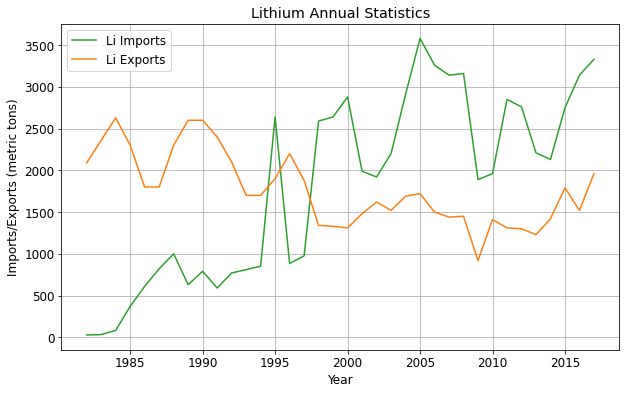

In [ ]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_li_data.loc[df_li_data["Year"] > 1981]["Year"], df_li_data.loc[df_li_data["Year"] > 1981]["Imports"], color='tab:green', label='Li Imports')
ax.plot(df_li_data.loc[df_li_data["Year"] > 1981]["Year"], df_li_data.loc[df_li_data["Year"] > 1981]["Exports"], color='tab:orange', label='Li Exports')

ax.set_xlabel('Year')
ax.set_ylabel('Imports/Exports (metric tons)')
ax.set_title('Lithium Annual Statistics')
ax.grid(True)
ax.legend(loc='upper left');